In [84]:
import pandas as pd
import numpy as np
from prophet import Prophet
from mango import Tuner
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from matplotlib import pyplot as plt

#### Default Model Training

In [85]:
# Load and prepare the dataset
merged_data = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/merged_data.csv')
merged_data['ds'] = pd.to_datetime(merged_data['ds'])
merged_data['ds'] = merged_data['ds'].dt.tz_localize(None)  # Remove timezone info if needed


# Filter data to the last 6 months
end_date = merged_data['ds'].max()
start_date = end_date - timedelta(days=180)
df = merged_data[(merged_data['ds'] >= start_date) & (merged_data['ds'] <= end_date)].reset_index(drop=True)


In [86]:
# Train-test split for Prophet model
train_df = df[df['ds'] < '2024-10-29 00:00:00']
test_df = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] < '2024-10-29 23:00:00')]

# Define and fit the Prophet model on training data
model = Prophet()
model.fit(train_df[['ds', 'y']])

# Define the future dataframe for the 23-hour prediction period on October 29, 2024
future = model.make_future_dataframe(periods=23, freq='h', include_history=False)
future = future[future['ds'] >= '2024-10-29 00:00:00']  # Limit to only October 29, 2024

# Make predictions
forecast = model.predict(future)


00:34:02 - cmdstanpy - INFO - Chain [1] start processing
00:34:02 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
future

,ds
0,2024-10-29 00:00:00
1,2024-10-29 01:00:00
2,2024-10-29 02:00:00
3,2024-10-29 03:00:00
4,2024-10-29 04:00:00
5,2024-10-29 05:00:00
6,2024-10-29 06:00:00
7,2024-10-29 07:00:00
8,2024-10-29 08:00:00
9,2024-10-29 09:00:00


In [88]:
# Calculate Root Mean Squared Error (RMSE)
error_rmse = np.sqrt(mean_squared_error(test_df['y'].values, forecast['yhat'].values))
print('Prediction RMSE error:', error_rmse)

Prediction RMSE error: 66.32825661100694


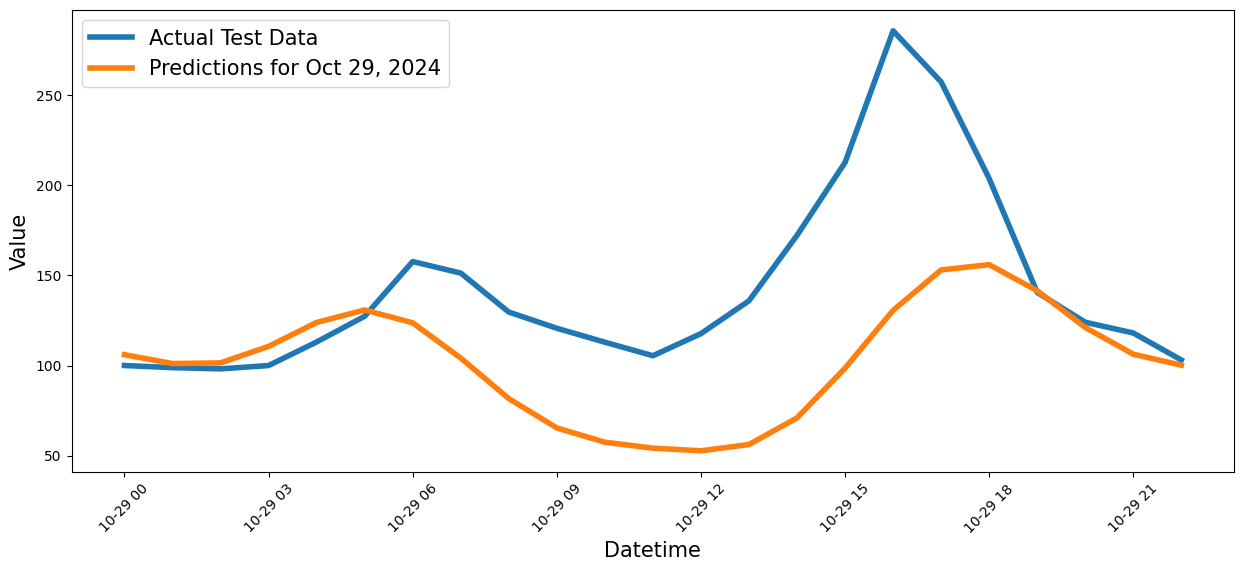

In [92]:
# Plot the predictions against the test data
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(test_df['ds'], test_df['y'], linewidth=4, label="Actual Test Data")
plt.plot(forecast['ds'], forecast['yhat'], linewidth=4, label="Predictions for Oct 29, 2024")

plt.legend(fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.xlabel('Datetime', fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [94]:
# add regressors to the model

# Train-test split for Prophet model
train_df = df[df['ds'] < '2024-10-29 00:00:00']
test_df = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] < '2024-10-29 23:00:00')]

# Define and fit the Prophet model on training data
model = Prophet()

# Add regressors to the Prophet model
regressors = ['temperature_2m', 'cloud_cover', 'wind_speed_10m', 'Biomass', 
              'Fossil brown coal / lignite', 'Fossil gas', 'Fossil hard coal', 
              'Hydro Run-of-River', 'Hydro water reservoir', 'Nuclear', 
              'Solar', 'Wind offshore', 'Wind onshore']

for regressor in regressors:
    model.add_regressor(regressor)

# Fit the model on the training data including regressors
model.fit(train_df[['ds', 'y'] + regressors])

# Define the future dataframe for the 23-hour prediction period on October 29, 2024
future = model.make_future_dataframe(periods=23, freq='h', include_history=False)

# Step 1: Create the future `ds` column manually (next 23 hours)
last_date = train_df['ds'].max()  # Get the last date from your training data
future_dates = [last_date + timedelta(hours=i) for i in range(1, 24)]  # Next 23 hours
future_df = pd.DataFrame({'ds': future_dates})

# Step 2: Add the regressor columns (with future values)
# You need to fill in the future regressor values here
# For example, using the last available value from the training data:
for regressor in regressors:
    future_df[regressor] = train_df[regressor].iloc[-1]  # Carry forward the last known value

# Now, future_df contains the future dates (ds) and the necessary regressor columns

# Step 3: Make predictions using the Prophet model
forecast_reg = model.predict(future_df)

# Print the forecasted values for the next 23 hours
forecast_reg


00:35:51 - cmdstanpy - INFO - Chain [1] start processing
00:35:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Biomass,Biomass_lower,Biomass_upper,Fossil brown coal / lignite,...,weekly,weekly_lower,weekly_upper,wind_speed_10m,wind_speed_10m_lower,wind_speed_10m_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-10-29 00:00:00,58.038841,5.579982,70.701615,58.038841,58.038841,-17.57153,-17.57153,-17.57153,-88.972353,...,9.321561,9.321561,9.321561,3.719756,3.719756,3.719756,0.0,0.0,0.0,38.142181
1,2024-10-29 01:00:00,58.016984,0.721172,66.273557,58.016984,58.016984,-17.57153,-17.57153,-17.57153,-88.972353,...,8.989090,8.989090,8.989090,3.719756,3.719756,3.719756,0.0,0.0,0.0,33.258959
2,2024-10-29 02:00:00,57.995128,0.496174,66.308626,57.995128,57.995128,-17.57153,-17.57153,-17.57153,-88.972353,...,8.631264,8.631264,8.631264,3.719756,3.719756,3.719756,0.0,0.0,0.0,33.855102
3,2024-10-29 03:00:00,57.973271,9.304558,75.317376,57.973271,57.973271,-17.57153,-17.57153,-17.57153,-88.972353,...,8.254329,8.254329,8.254329,3.719756,3.719756,3.719756,0.0,0.0,0.0,43.315685
4,2024-10-29 04:00:00,57.951415,21.782252,90.980067,57.951415,57.951415,-17.57153,-17.57153,-17.57153,-88.972353,...,7.864438,7.864438,7.864438,3.719756,3.719756,3.719756,0.0,0.0,0.0,57.037677
5,2024-10-29 05:00:00,57.929558,32.964663,98.439029,57.929558,57.929558,-17.57153,-17.57153,-17.57153,-88.972353,...,7.467573,7.467573,7.467573,3.719756,3.719756,3.719756,0.0,0.0,0.0,64.818081
6,2024-10-29 06:00:00,57.907702,27.611589,93.133865,57.907702,57.907702,-17.57153,-17.57153,-17.57153,-88.972353,...,7.069479,7.069479,7.069479,3.719756,3.719756,3.719756,0.0,0.0,0.0,59.211573
7,2024-10-29 07:00:00,57.885845,8.586386,74.809851,57.885845,57.885845,-17.57153,-17.57153,-17.57153,-88.972353,...,6.675598,6.675598,6.675598,3.719756,3.719756,3.719756,0.0,0.0,0.0,41.894990
8,2024-10-29 08:00:00,57.863989,-10.715715,55.326299,57.863989,57.863989,-17.57153,-17.57153,-17.57153,-88.972353,...,6.291008,6.291008,6.291008,3.719756,3.719756,3.719756,0.0,0.0,0.0,21.971725
9,2024-10-29 09:00:00,57.842133,-23.321763,40.645349,57.842133,57.842133,-17.57153,-17.57153,-17.57153,-88.972353,...,5.920369,5.920369,5.920369,3.719756,3.719756,3.719756,0.0,0.0,0.0,8.063082


In [95]:
# Calculate Root Mean Squared Error (RMSE)
error_rmse = np.sqrt(mean_squared_error(test_df['y'].values, forecast_reg['yhat'].values))
print('Prediction RMSE error:', error_rmse)

Prediction RMSE error: 113.91723508929327


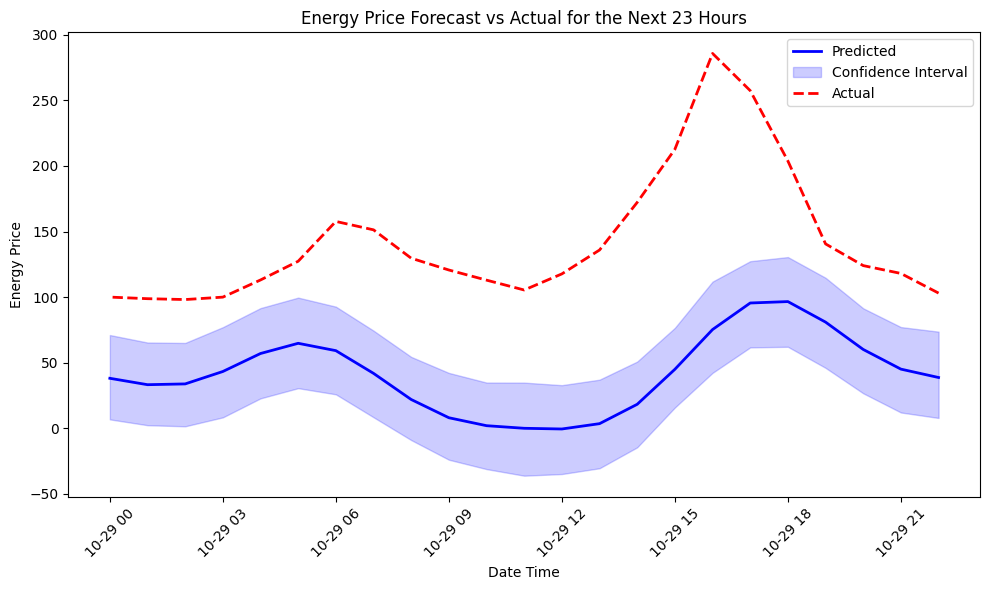

In [91]:
# Plot the predictions with confidence intervals and actual test data

plt.figure(figsize=(10, 6))

# Plot the predicted values (yhat)
plt.plot(forecast_reg['ds'], forecast_reg['yhat'], label='Predicted', color='blue', linestyle='-', linewidth=2)

# Plot the confidence intervals
plt.fill_between(forecast_reg['ds'], forecast_reg['yhat_lower'], forecast_reg['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')

# Plot the actual test data
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Date Time')
plt.ylabel('Energy Price')
plt.title('Energy Price Forecast vs Actual for the Next 23 Hours')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

#### Hyperparameter Optimization

In [68]:
# Define the RMSE function
def rmse(y_true, y_pred):
    """Root Mean Squared Error"""
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)

In [10]:
# Define the objective function for tuning
def objective_function(args_list):
    results = []

    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)

            # Define future dates for October 29, 2024, hourly prediction
            future = model.make_future_dataframe(periods=23, freq='h', include_history=False)
            future = future[future['ds'] >= '2024-10-29 00:00:00']

            # Make predictions
            forecast = model.predict(future)
            predictions_tuned = forecast['yhat'].values

            # Calculate error using RMSE
            error = rmse(test_df['y'].values, predictions_tuned)
            results.append(error)
        except Exception as e:
            # Assign a high error if the model fails to fit
            results.append(1000.0)

    return results


# Define the hyperparameter search space
param_space = dict(
    growth=['linear', 'logistic'],  # Avoid 'flat' as it might lead to errors
    n_changepoints=range(0, 50, 5),
    changepoint_range=uniform(0.5, 0.5),
    yearly_seasonality=[True, False],
    weekly_seasonality=[True, False],
    daily_seasonality=[True, False],
    seasonality_mode=['additive', 'multiplicative'],
    seasonality_prior_scale=uniform(5.0, 15.0),
    changepoint_prior_scale=uniform(0.01, 0.1),
    interval_width=uniform(0.2, 0.8),
    uncertainty_samples=[500, 1000, 1500, 2000]
)

# Configuration for Mango's Tuner
conf_Dict = {
    'initial_random': 10,
    'num_iteration': 50
}

# Create the Tuner and perform the hyperparameter tuning
tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()

# Print best parameters and loss
print('Best parameters:', results['best_params'])
print('Best loss (RMSE):', results['best_objective'])


23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing
23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing
23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing
23:34:41 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/50 [00:00<?, ?it/s]

23:34:45 - cmdstanpy - INFO - Chain [1] start processing
23:34:45 - cmdstanpy - INFO - Chain [1] done processing
23:34:47 - cmdstanpy - INFO - Chain [1] start processing
23:34:47 - cmdstanpy - INFO - Chain [1] done processing
23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:49 - cmdstanpy - INFO - Chain [1] done processing
23:34:51 - cmdstanpy - INFO - Chain [1] start processing
23:34:51 - cmdstanpy - INFO - Chain [1] done processing
23:34:57 - cmdstanpy - INFO - Chain [1] start processing
23:34:57 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:08 - cmdstanpy - INFO - Chain [1] start processing
23:35:08 - cmdstanpy - INFO - Chain [1] done processing
23:35:10 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1]

Best parameters: {'changepoint_prior_scale': 0.09319506625882018, 'changepoint_range': 0.7436604084124901, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.9266921461364723, 'n_changepoints': 40, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.012832271371659, 'uncertainty_samples': 2000, 'weekly_seasonality': True, 'yearly_seasonality': True}
Best loss (RMSE): 50.18


In [72]:
# Train the best model with tuned hyperparameters
best_params = {
    'changepoint_prior_scale': 0.059,
    'changepoint_range': 0.83,
    'daily_seasonality': False,
    'growth':'linear',
    'interval_width': 0.9,
    'n_changepoints': 15,
    'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 10.2,
    'uncertainty_samples': 10,
    'weekly_seasonality': True,
    'yearly_seasonality': True
}

# Create the model with the best parameters
best_model = Prophet(**best_params)

# Fit the model on the training data
best_model.fit(train_df)

# Define future dataframe for prediction
Test_size = 23  # Number of hours in the test period
future = best_model.make_future_dataframe(periods=Test_size, freq='h', include_history=True)

# Get the forecast from the model
forecast = best_model.predict(future)

# Extract the tuned predictions for the test period
predictions_tuned = forecast[forecast['ds'].isin(test_df['ds'])]


00:26:20 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing


In [100]:
predictions_tuned

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
4298,2024-10-29 00:00:00,37.563116,69.722219,177.440390,37.563116,37.563116,2.921199,2.921199,2.921199,0.596361,0.596361,0.596361,2.324838,2.324838,2.324838,0.0,0.0,0.0,147.292438
4299,2024-10-29 01:00:00,37.598844,104.019894,186.275853,37.598844,37.598844,2.903371,2.903371,2.903371,0.574189,0.574189,0.574189,2.329183,2.329183,2.329183,0.0,0.0,0.0,146.762240
4300,2024-10-29 02:00:00,37.634572,86.535672,216.926063,37.634572,37.634572,2.883691,2.883691,2.883691,0.550181,0.550181,0.550181,2.333510,2.333510,2.333510,0.0,0.0,0.0,146.161050
4301,2024-10-29 03:00:00,37.670299,91.853924,207.208496,37.670299,37.670299,2.862563,2.862563,2.862563,0.524742,0.524742,0.524742,2.337821,2.337821,2.337821,0.0,0.0,0.0,145.503906
4302,2024-10-29 04:00:00,37.706027,71.720338,202.141760,37.706027,37.706027,2.840390,2.840390,2.840390,0.498277,0.498277,0.498277,2.342113,2.342113,2.342113,0.0,0.0,0.0,144.805865
4303,2024-10-29 05:00:00,37.741755,99.213966,182.825417,37.741755,37.741755,2.817571,2.817571,2.817571,0.471184,0.471184,0.471184,2.346387,2.346387,2.346387,0.0,0.0,0.0,144.081818
4304,2024-10-29 06:00:00,37.777483,77.187071,187.288826,37.777483,37.789595,2.794491,2.794491,2.794491,0.443849,0.443849,0.443849,2.350642,2.350642,2.350642,0.0,0.0,0.0,143.346323
4305,2024-10-29 07:00:00,37.813210,81.949217,173.118800,37.813210,37.849547,2.771524,2.771524,2.771524,0.416646,0.416646,0.416646,2.354878,2.354878,2.354878,0.0,0.0,0.0,142.613440
4306,2024-10-29 08:00:00,37.848938,98.358243,222.208361,37.848938,37.909499,2.749024,2.749024,2.749024,0.389930,0.389930,0.389930,2.359094,2.359094,2.359094,0.0,0.0,0.0,141.896575
4307,2024-10-29 09:00:00,37.884666,93.044430,193.785426,37.884666,37.969452,2.727322,2.727322,2.727322,0.364031,0.364031,0.364031,2.363291,2.363291,2.363291,0.0,0.0,0.0,141.208334


In [99]:
rmse(test_df['y'].values, predictions_tuned['yhat'].values)

49.32

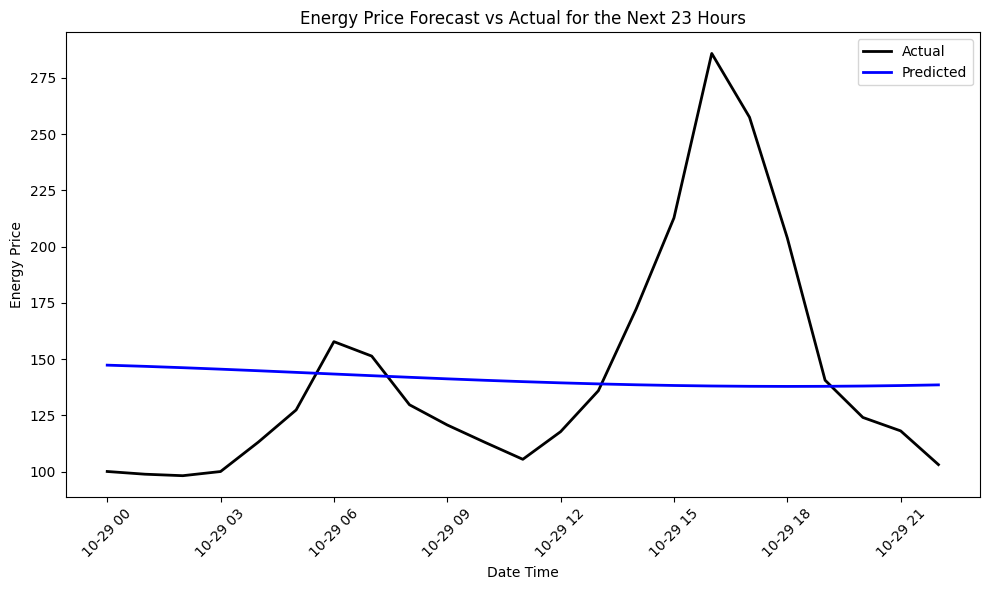

In [98]:

# Plot the actual values (from test_df)
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='black', linestyle='-', linewidth=2)

# Plot the predicted values (yhat from forecast)
plt.plot(predictions_tuned['ds'], predictions_tuned['yhat'], label='Predicted', color='blue', linestyle='-', linewidth=2)


# Add labels and title
plt.xlabel('Date Time')
plt.ylabel('Energy Price')
plt.title('Energy Price Forecast vs Actual for the Next 23 Hours')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [96]:
# Define the number of periods (hours in this case)
periods = 23

# Step 1: Create the future `ds` column manually (next 23 hours)
last_date = train_df['ds'].max()  # Get the last date from your training data
future_dates = [last_date + timedelta(hours=i) for i in range(1, periods + 1)]
future_df = pd.DataFrame({'ds': future_dates})

# Step 2: Add the regressor columns (with future values)
regressors = ['temperature_2m', 'cloud_cover', 'wind_speed_10m', 'Biomass', 'Fossil brown coal / lignite', 
              'Fossil gas', 'Fossil hard coal', 'Hydro Run-of-River', 'Hydro water reservoir', 
              'Nuclear', 'Solar', 'Wind offshore', 'Wind onshore']

# You need to fill in the future regressor values here
# For example, using the last available value from the training data:
for regressor in regressors:
    future_df[regressor] = train_df[regressor].iloc[-1]  # Carry forward the last known value

# Now, future_df contains the future dates (ds) and the necessary regressor columns

# Step 3: Make predictions using the Prophet model
forecast_reg = best_model.predict(future_df)

# Print the forecasted values for the next 23 hours
print(forecast_reg[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
 

                    ds        yhat  yhat_lower  yhat_upper
0  2024-10-29 00:00:00  147.292438   98.079152  193.969971
1  2024-10-29 01:00:00  146.762240   97.401853  207.007029
2  2024-10-29 02:00:00  146.161050   74.745132  183.013713
3  2024-10-29 03:00:00  145.503906   67.132888  169.297444
4  2024-10-29 04:00:00  144.805865  101.202536  184.523255
5  2024-10-29 05:00:00  144.081818   95.017433  184.141539
6  2024-10-29 06:00:00  143.346323   96.507132  193.977936
7  2024-10-29 07:00:00  142.613440   91.777293  210.589993
8  2024-10-29 08:00:00  141.896575   58.657260  191.065534
9  2024-10-29 09:00:00  141.208334  113.769522  199.789629
10 2024-10-29 10:00:00  140.560392   82.477186  215.111808
11 2024-10-29 11:00:00  139.963376   85.993143  206.914661
12 2024-10-29 12:00:00  139.426759   45.792375  194.316803
13 2024-10-29 13:00:00  138.958774  101.729449  222.930098
14 2024-10-29 14:00:00  138.566351   68.343921  168.879345
15 2024-10-29 15:00:00  138.255054  119.268587  209.1607

In [76]:
forecast_reg

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2024-10-29 00:00:00,37.563116,77.854429,259.867572,37.563116,37.563116,2.921199,2.921199,2.921199,0.596361,0.596361,0.596361,2.324838,2.324838,2.324838,0.0,0.0,0.0,147.292438
1,2024-10-29 01:00:00,37.598844,99.942762,188.401354,37.598844,37.598844,2.903371,2.903371,2.903371,0.574189,0.574189,0.574189,2.329183,2.329183,2.329183,0.0,0.0,0.0,146.762240
2,2024-10-29 02:00:00,37.634572,100.104077,200.536402,37.634572,37.634572,2.883691,2.883691,2.883691,0.550181,0.550181,0.550181,2.333510,2.333510,2.333510,0.0,0.0,0.0,146.161050
3,2024-10-29 03:00:00,37.670299,80.986834,195.043348,37.670299,37.670299,2.862563,2.862563,2.862563,0.524742,0.524742,0.524742,2.337821,2.337821,2.337821,0.0,0.0,0.0,145.503906
4,2024-10-29 04:00:00,37.706027,80.759344,197.662020,37.706027,37.706027,2.840390,2.840390,2.840390,0.498277,0.498277,0.498277,2.342113,2.342113,2.342113,0.0,0.0,0.0,144.805865
5,2024-10-29 05:00:00,37.741755,98.012195,166.173606,37.741755,37.741755,2.817571,2.817571,2.817571,0.471184,0.471184,0.471184,2.346387,2.346387,2.346387,0.0,0.0,0.0,144.081818
6,2024-10-29 06:00:00,37.777483,59.782397,207.849476,37.777483,37.777483,2.794491,2.794491,2.794491,0.443849,0.443849,0.443849,2.350642,2.350642,2.350642,0.0,0.0,0.0,143.346323
7,2024-10-29 07:00:00,37.813210,116.428047,208.396458,37.813210,37.813210,2.771524,2.771524,2.771524,0.416646,0.416646,0.416646,2.354878,2.354878,2.354878,0.0,0.0,0.0,142.613440
8,2024-10-29 08:00:00,37.848938,88.063696,209.208571,37.848938,37.848938,2.749024,2.749024,2.749024,0.389930,0.389930,0.389930,2.359094,2.359094,2.359094,0.0,0.0,0.0,141.896575
9,2024-10-29 09:00:00,37.884666,87.885720,218.558387,37.884666,37.884666,2.727322,2.727322,2.727322,0.364031,0.364031,0.364031,2.363291,2.363291,2.363291,0.0,0.0,0.0,141.208334


In [77]:
rmse(test_df['y'].values, forecast_reg['yhat'].values)

49.32

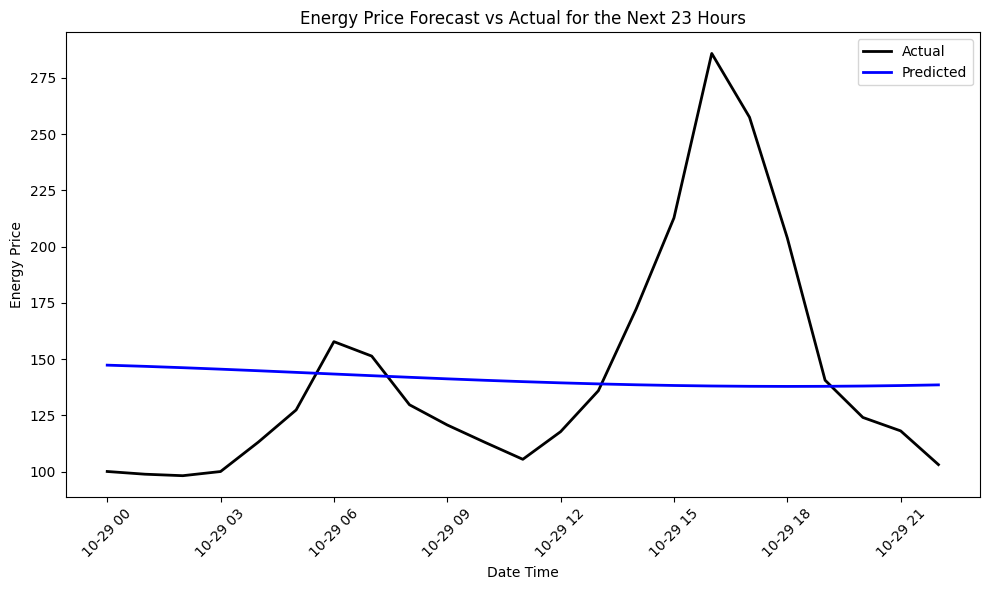

In [97]:

# Plot the actual values (from test_df)
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='black', linestyle='-', linewidth=2)

# Plot the predicted values (yhat from forecast)
plt.plot(forecast_reg['ds'], forecast_reg['yhat'], label='Predicted', color='blue', linestyle='-', linewidth=2)


# Add labels and title
plt.xlabel('Date Time')
plt.ylabel('Energy Price')
plt.title('Energy Price Forecast vs Actual for the Next 23 Hours')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### 

In [98]:
from mango.tuner import Tuner
from mango.domain.distribution import loguniform
import matplotlib.pyplot as plt
import os


In [67]:
print(train_df)
print(test_df)

                      ds       y  temperature_2m  cloud_cover  wind_speed_10m  \
23   2024-10-28 23:00:00  101.34          11.683         95.0        7.790070   
24   2024-10-28 22:00:00  102.41          11.683         88.0        8.714677   
25   2024-10-28 21:00:00  109.96          11.833         98.0        8.538150   
26   2024-10-28 20:00:00  115.59          11.383        100.0        6.638072   
27   2024-10-28 19:00:00  124.19          11.583         85.0        7.001514   
...                  ...     ...             ...          ...             ...   
4316 2024-05-03 02:00:00   59.14          12.983         59.0        9.366919   
4317 2024-05-03 01:00:00   58.50          13.333         24.0        9.255571   
4318 2024-05-03 00:00:00   57.95          12.833         59.0       11.165805   
4319 2024-05-02 23:00:00   59.14          13.183         12.0        8.669949   
4320 2024-05-02 22:00:00   61.90          13.433          0.0        7.862518   

       Biomass  Fossil brow

In [68]:
param_dict = {
    "changepoint_prior_scale": loguniform(-3, 4),
    "seasonality_prior_scale": loguniform(1, 2),
    "n_changepoints": range(5, 50, 5),
    "yearly_seasonality": [True, False],
    "weekly_seasonality": [True, False],
    "daily_seasonality": [True, False]
}


In [74]:
def objective_Prophet(args_list):
    global train_df, test_df, validate_df
    hyper_evaluated = []
    results = []

    for hyper_par in args_list:
        clf = Prophet(**hyper_par)
        clf.fit(train_df)

        # Make predictions on the validation set
        future = clf.make_future_dataframe(periods=23, freq='h')
        forecast = clf.predict()
        
        # Evaluate the performance using RMSE
        y_pred = forecast['yhat'].values[-len(test_df):]
        mse = mean_squared_error(test_df['y'], y_pred)
        mse = mse / 10e5  # Normalize the error
        result = (-1.0) * mse  # We want to maximize (hence the negative)
        results.append(result)
        hyper_evaluated.append(hyper_par)
        
    return hyper_evaluated, results


In [75]:
conf_Dict = {
    'batch_size': 2,
    'num_iteration': 10,
    'initial_random': 5
}

# Initialize the tuner with the search space, objective function, and configuration
tuner_user = Tuner(param_dict, objective_Prophet, conf_Dict)
results = tuner_user.maximize()


23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:07 - cmdstanpy - INFO - Chain [1] done processing
23:10:07 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing
23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing
23:10:09 - cmdstanpy - INFO - Chain [1] start processing
23:10:09 - cmdstanpy - INFO - Chain [1] done processing
23:10:10 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

23:10:12 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing
23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing
23:10:16 - cmdstanpy - INFO - Chain [1] start processing
23:10:16 - cmdstanpy - INFO - Chain [1] done processing
23:10:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:10:16 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing
23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing
23:10:23 - cmdstanpy - INFO - Chain [1] start process

In [89]:
print('Best hyperparameters:', results['best_params'])
print('Best objective value:', results['best_objective'])


Best hyperparameters: {'changepoint_prior_scale': 0.001210738174678744, 'daily_seasonality': False, 'n_changepoints': 45, 'seasonality_prior_scale': 13.091932484831352, 'weekly_seasonality': True, 'yearly_seasonality': True}
Best objective value: -0.0028953511811280657


In [90]:
best_params = results['best_params']
model = Prophet(**best_params)

# Train the model on the training data
model.fit(train_df)


23:19:08 - cmdstanpy - INFO - Chain [1] start processing
23:19:09 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
# Ensure that 'ds' column in your DataFrame is in datetime format
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Fit the model to the training data
model = Prophet(**best_params)
model.fit(train_df)

# Make future predictions for 23 periods (since len(test_df) is 23)
future = model.make_future_dataframe(train_df, periods=23, freq='H', include_history=False)

# Make predictions on the future data
forecast = model.predict(future)

# Extract the predictions for the test period (from the forecasted values)
predictions = forecast[forecast['ds'].isin(test_df['ds'])]

23:19:18 - cmdstanpy - INFO - Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing


TypeError: Prophet.make_future_dataframe() got multiple values for argument 'periods'

NameError: name 'predictions' is not defined

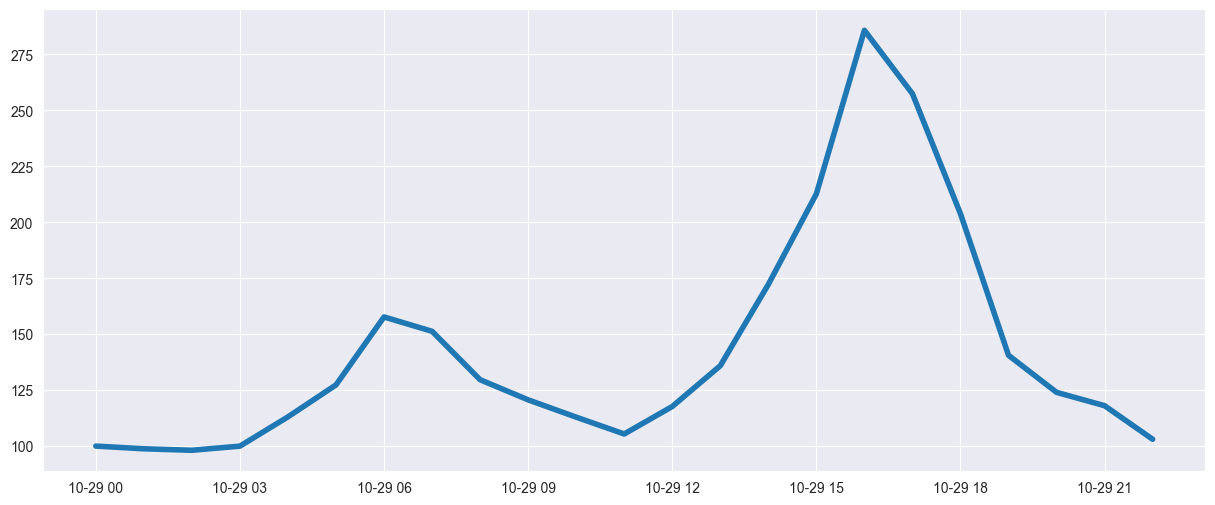

In [92]:

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', linewidth=4)
plt.plot(predictions['ds'], predictions['yhat'], label='Predicted', linewidth=4)
plt.legend()
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.xticks(rotation=45)
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.show()


In [93]:
# Evaluate the performance
test_rmse = np.sqrt(mean_squared_error(test_df['y'], predictions['yhat']))
print('Test RMSE:', test_rmse)


NameError: name 'predictions' is not defined

NameError: name 'predictions' is not defined

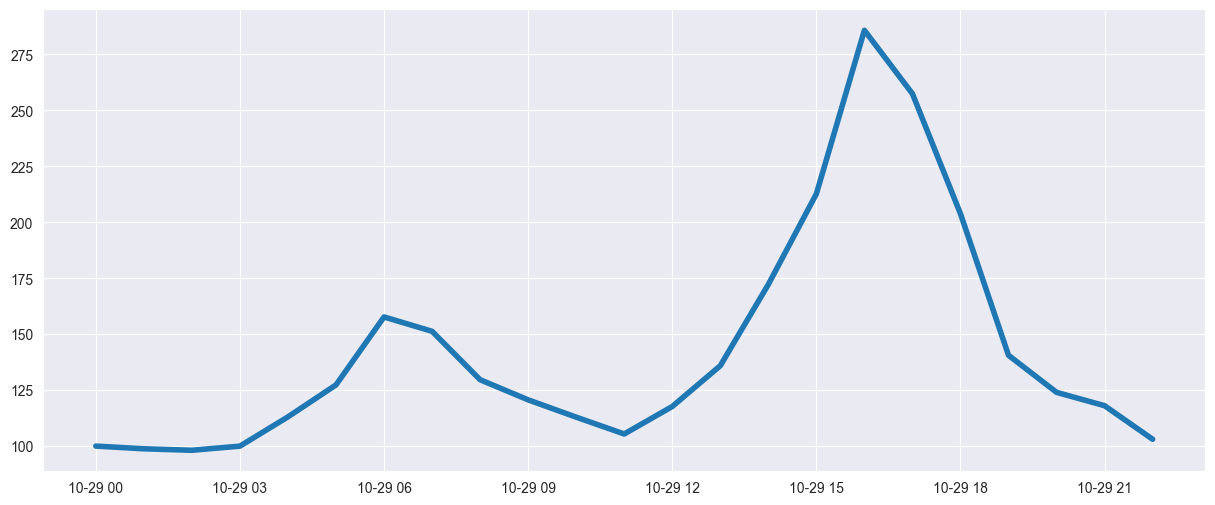

In [94]:
# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', linewidth=4)
plt.plot(predictions['ds'], predictions['yhat'], label='Predicted', linewidth=4)
plt.legend()
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.xticks(rotation=45)
plt.title('Actual vs Predicted for Test Data', fontsize=20)
plt.show()


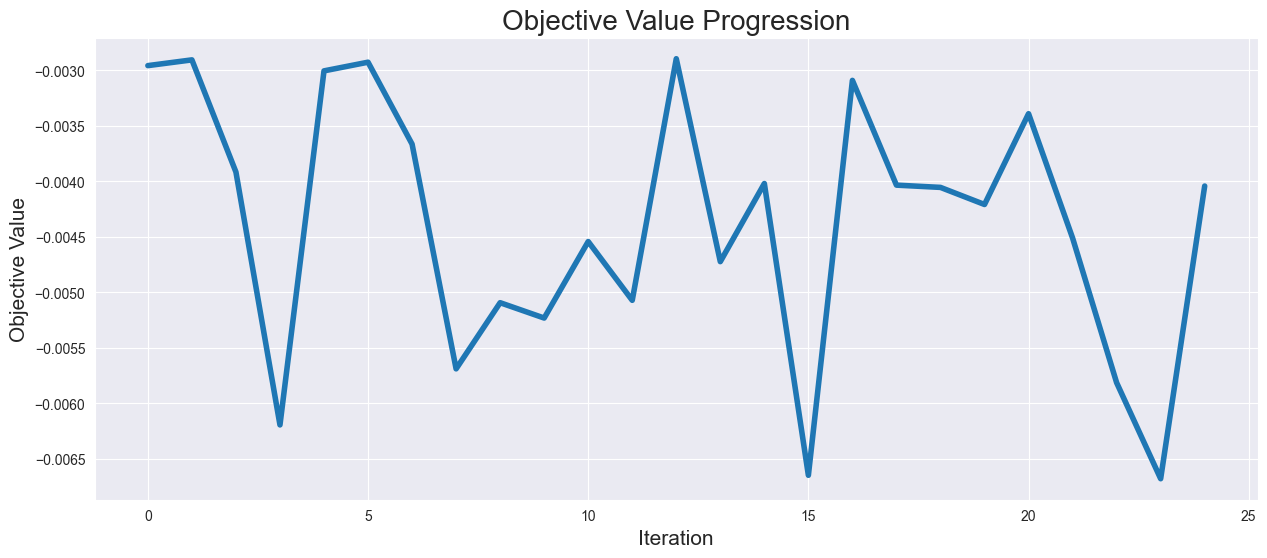

In [95]:
plt.figure(figsize=(15, 6))
plt.plot(results['objective_values'], lw=4)
plt.title('Objective Value Progression', fontsize=20)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Objective Value', fontsize=15)
plt.show()
